In [1]:
import Bio as bp 
import pysam
import h5py
import pandas as pd
import numpy as np
import seaborn as sns 
import scipy
import matplotlib.pyplot as plt

In [2]:
# function to extract info from Tapestri H5 files
def extract_tapestri(tapestri_file):
    '''
    INPUT: A Tapestri CNV + SNV file in HD5 format
    OUTPUT:
        1. cells: Dataframe of information about all selected cells
        2. amplicons: Dataframe of information for targeted amplicons
        3. read_counts: Dataframe of sequencing read counts per cell barcode (index) and amplicon (columns)
        4: variants: Dataframe of information for inferred SNVs
        5. vafs : Dataframe of variant allele frequencies per cell barcode (index) and SNV (columns)
        6. covs : Dataframe of total sequencing coverage per cell barcode (index) and SNV (columns)
        7. filtermask: Dataframe of filtered masks per cell barcode (index) and SNV (columns)
        8. gqs: Dataframe of VCF-score GQS per cell barcode (index) and SNV (columns)
        9. ngts: Dataframe of VCF-score NGTS per cell barcode (index) and SNV (columns)
        10. rgqs: Dataframe of VCF-score RGQS per cell barcode (index) and SNV (columns)
        11: cell_filters: Dataframe of filtered cells
    '''
    with h5py.File(tapestri_file, "r") as f:
        read_counts = pd.DataFrame(data=f['assays']['dna_read_counts']['layers']['read_counts'][:],
                                index=f['assays']['dna_read_counts']['ra']['barcode'][:],
                                columns=f['assays']['dna_read_counts']['ca']['id'][:])
        cells = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ra'].items()})
        amplicons = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_read_counts']['ca'].items()})
    with h5py.File(tapestri_file, "r") as f:
        variants = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ca'].items()})
        vafs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['AF'][:] / 100.0,
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        covs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['DP'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        filtermask = pd.DataFrame(data=f['assays']['dna_variants']['layers']['FILTER_MASK'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        gqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['GQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        ngts = pd.DataFrame(data=f['assays']['dna_variants']['layers']['NGT'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        rgqs = pd.DataFrame(data=f['assays']['dna_variants']['layers']['RGQ'][:],
                            index=f['assays']['dna_variants']['ra']['barcode'][:],
                            columns=f['assays']['dna_variants']['ca']['id'][:])
        cell_filters = pd.DataFrame({k : v[:] for k, v in f['assays']['dna_variants']['ra'].items()})
    return cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters

In [3]:
cells, amplicons, read_counts, variants, vafs, covs, filtermask, gqs, ngts, rgqs, cell_filters = extract_tapestri("./data/4-cell-lines-AML-CNV.dna.h5")

# Single cell sequencing simulation

### Panel reference genome creation

- <font color='green'>dowload human reference genome, called ref_human_genome.fa </font>

### Get info of the panel (id , chromosome, position)

In [4]:
amplicon_search = amplicons[['id','CHROM','start_pos','end_pos']].copy()
amplicon_search.CHROM = amplicon_search.CHROM.apply(lambda x : 'chr'+str(int(x)))
amplicon_search.id = amplicon_search.id.apply(str)
amplicon_search

,id,CHROM,start_pos,end_pos
0,b'AML_v2_NRAS_115256512',chr1,115256488,115256723
1,b'AML_v2_NRAS_115258635',chr1,115258610,115258825
2,b'AML_v2_DNMT3A_25457166',chr2,25457144,25457372
3,b'AML_v2_DNMT3A_25458540',chr2,25458519,25458763
4,b'AML_v2_DNMT3A_25459813',chr2,25459794,25460046
...,...,...,...,...
122,b'AML_v2_RUNX1_36206703',chr21,36206684,36206913
123,b'AML_v2_RUNX1_36231714',chr21,36231693,36231937
124,b'AML_v2_RUNX1_36252844',chr21,36252820,36253046
125,b'AML_v2_U2AF1_44514570',chr21,44514550,44514808


#### reformat for small experiment

In [5]:
all_start = [np.random.randint(low=1,high=2200) for _ in range(127)] 
while np.unique(all_start).shape[0] < 127:
    all_start = [np.random.randint(low=1,high=2200) for _ in range(127)] 
    all_end = [s + 200 for s in all_start ]
np.unique(all_start).shape

(127,)

In [6]:
amplicon_search['start_pos'] = all_start
amplicon_search['end_pos'] = all_end

### final dataframe

In [7]:
amplicon_search

,id,CHROM,start_pos,end_pos
0,b'AML_v2_NRAS_115256512',chr1,1322,1522
1,b'AML_v2_NRAS_115258635',chr1,1275,1475
2,b'AML_v2_DNMT3A_25457166',chr2,691,891
3,b'AML_v2_DNMT3A_25458540',chr2,1700,1900
4,b'AML_v2_DNMT3A_25459813',chr2,803,1003
...,...,...,...,...
122,b'AML_v2_RUNX1_36206703',chr21,1423,1623
123,b'AML_v2_RUNX1_36231714',chr21,332,532
124,b'AML_v2_RUNX1_36252844',chr21,1224,1424
125,b'AML_v2_U2AF1_44514570',chr21,1858,2058


In [8]:
# cut the reference genome to recover amplicon sequence

from Bio import SeqIO
from Bio.SeqUtils import gc_fraction 

with open("./genomes/panel_genome.fa", "w") as file : # ref human genome
    GC_content = {}

    for seq_record in SeqIO.parse("./genomes/ref_genome.fa", "fasta"): # loop over chr 
        print(seq_record.id) # chr name 
        #print(repr(seq_record.seq)) # sequence 
        print(len(seq_record)) # length
        
        amplicon_in_seqrecord = amplicon_search[amplicon_search.CHROM == seq_record.id]
        if amplicon_in_seqrecord.size != 0: # some amplicon in chr : test
            for id, row in amplicon_in_seqrecord.iterrows(): #loop over amplicon in chr 
                id,chrom,start,end = row
                file.write(">"+ str(id)+"\n") # write id of amplicon
                amplicon_seq = seq_record.seq[start:end+1] # +1 because last excluded, get amplicon sequence
                file.write(str(amplicon_seq)+"\n")
                GC_content[id] = gc_fraction(amplicon_seq) 


chr1
2346
chr2
2346


In [11]:
# cut the reference genome to recover amplicon sequence

from Bio import SeqIO
from Bio.SeqUtils import gc_fraction 

#file = open("./genomes/panel_genome.fa", "w") # ref human genome
GC_content = {}

for seq_record in SeqIO.parse("./genomes/ref_genome.fa", "fasta"): # loop over chr 
    print(type(seq_record)) # chr name 
    #print(repr(seq_record.seq)) # sequence 
    print(len(seq_record)) # length
    
"""    amplicon_in_seqrecord = amplicon_search[amplicon_search.CHROM == seq_record.id]
    if amplicon_in_seqrecord.size != 0: # some amplicon in chr : test
        for id, row in amplicon_in_seqrecord.iterrows(): #loop over amplicon in chr 
            id,chrom,start,end = row
            file.write(">"+ str(id)+"\n") # write id of amplicon
            amplicon_seq = seq_record.seq[start:end+1] # +1 because last excluded, get amplicon sequence
            file.write(str(amplicon_seq)+"\n")
            GC_content[id] = gc_fraction(amplicon_seq) 
file.close()"""

<class 'Bio.SeqRecord.SeqRecord'>
2346
<class 'Bio.SeqRecord.SeqRecord'>
2346


'    amplicon_in_seqrecord = amplicon_search[amplicon_search.CHROM == seq_record.id]\n    if amplicon_in_seqrecord.size != 0: # some amplicon in chr : test\n        for id, row in amplicon_in_seqrecord.iterrows(): #loop over amplicon in chr \n            id,chrom,start,end = row\n            file.write(">"+ str(id)+"\n") # write id of amplicon\n            amplicon_seq = seq_record.seq[start:end+1] # +1 because last excluded, get amplicon sequence\n            file.write(str(amplicon_seq)+"\n")\n            GC_content[id] = gc_fraction(amplicon_seq) \nfile.close()'

In [9]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import gc_fraction 

GC_content = {}
sequences = []

for seq_record in SeqIO.parse("./genomes/ref_genome.fa", "fasta"): # loop over chr 
    print(seq_record.id) # chr name 
    print(len(seq_record)) # length
    
    amplicon_in_seqrecord = amplicon_search[amplicon_search.CHROM == seq_record.id]
    if amplicon_in_seqrecord.size != 0: # some amplicon in chr : test
        for id, row in amplicon_in_seqrecord.iterrows(): #loop over amplicon in chr 
            id,chrom,start,end = row
            amplicon_seq = seq_record.seq[start:end+1] # +1 because last excluded, get amplicon sequence
            GC_content[id] = gc_fraction(amplicon_seq) 
            sequences.append(SeqRecord(amplicon_seq,id = id))

with open("./genomes/panel_genome.fa", "w") as output_handle:
    SeqIO.write(sequences, output_handle, "fasta")

""""sequences = [seq_record for seq_record in SeqIO.parse("./genomes/ref_genome.fa", "fasta")]  # add code here
with open("example.fasta", "w") as output_handle:|--
    SeqIO.write(sequences, output_handle, "fasta")"""

#Bio.SeqIO.to_dict() to turn a SeqRecord iterator (or list) into a dictionary (in memory):
#SeqRecord to set id 
# what is the type of SeqIO.parse

#record = SeqRecord(Seq("MKQHKAMIVALIVICITAVVAALVTRKDLCEVHIRTGQTEVAVF",


chr1
2346
chr2
2346


'"sequences = [seq_record for seq_record in SeqIO.parse("./genomes/ref_genome.fa", "fasta")]  # add code here\nwith open("example.fasta", "w") as output_handle:|--\n    SeqIO.write(sequences, output_handle, "fasta")'

- gc_fraction(seq) : gives GC fraction for a seq

- art_illumina -ss HS25 -na -i panel_genome.fa -p -l 100 -f 50 -m 101 -s 1 -o paired_seq
( -ss sequencing system, -l r1/r2 length, -m fragment size)
- bwa index panel_genome.fa
- bwa mem panel_genome.fa paired_seq1.fq paired_seq2.fq | samtools sort -Obam -o align_seq.sorted.bam (alignment)
- samtools index align_seq.sorted.bam

<font color='green'>For art illumina should I simulate from panel_genome or panel_genome modified with detected SNV ? </font>

# Analysis

<font color='green'>Normalization with total generated reads or mapped ? </font>

In [21]:
samfile = pysam.AlignmentFile("./genomes/align_seq.sorted.bam", "rb") # open alignment sorted file
read_counts_info = {}
nb_mapped_reads = samfile.mapped #number of mapped read
for id in samfile.references:
    read_counts_info[id] = []
    read_counts_info[id].append(samfile.count(region= id)) #total nb of overlapping reads
    read_counts_info[id].append(read_counts_info[id][-1]/nb_mapped_reads) # proportion of overlapping reads
    read_counts_info[id].append(GC_content[id]) #gc fraction
    
    #print(len([r for r in samfile.fetch(region= id)]), samfile.count(region= id), samfile.count_coverage(contig=id ))

In [22]:
read_counts_info

{"b'AML_v2_NRAS_115256512'": [100, 0.0425531914893617, 0.5174129353233831],
 "b'AML_v2_NRAS_115258635'": [98, 0.04170212765957447, 0.46766169154228854],
 "b'AML_v2_DNMT3A_25457166'": [88, 0.0374468085106383, 0.5024875621890548],
 "b'AML_v2_DNMT3A_25458540'": [86, 0.03659574468085106, 0.5522388059701493],
 "b'AML_v2_DNMT3A_25459813'": [95, 0.04042553191489362, 0.4577114427860697],
 "b'AML_v2_DNMT3A_25461902'": [95, 0.04042553191489362, 0.5024875621890548],
 "b'AML_v2_DNMT3A_25463127'": [107, 0.04553191489361702, 0.48756218905472637],
 "b'AML_v2_DNMT3A_25463515'": [106, 0.0451063829787234, 0.48756218905472637],
 "b'AML_v2_DNMT3A_25464443'": [101, 0.04297872340425532, 0.5472636815920398],
 "b'AML_v2_DNMT3A_25466642'": [96, 0.04085106382978723, 0.5124378109452736],
 "b'AML_v2_DNMT3A_25467033'": [109, 0.04638297872340426, 0.527363184079602],
 "b'AML_v2_DNMT3A_25467391'": [93, 0.03957446808510638, 0.4925373134328358],
 "b'AML_v2_DNMT3A_25468130'": [101, 0.04297872340425532, 0.542288557213930

- fetch : give sequence of overlapping reads
- count : give the number of overlapping reads
- count coverage : for each nucleotide type give number of reads with this nt at each position (.buffer_info())
- samfile.mapped : give the number of mapped reads
- samfile.unmapped : give the number of unmapped reads


- get_overlap(seq, start,end) : give number of nt that overlapp the region start/end

In [23]:
normal_cell_expectation = pd.DataFrame(read_counts_info).T.rename(columns={0:'reads', 1:'prop', 2 :'GC'})
normal_cell_expectation

,reads,prop,GC
b'AML_v2_NRAS_115256512',100.0,0.042553,0.517413
b'AML_v2_NRAS_115258635',98.0,0.041702,0.467662
b'AML_v2_DNMT3A_25457166',88.0,0.037447,0.502488
b'AML_v2_DNMT3A_25458540',86.0,0.036596,0.552239
b'AML_v2_DNMT3A_25459813',95.0,0.040426,0.457711
b'AML_v2_DNMT3A_25461902',95.0,0.040426,0.502488
b'AML_v2_DNMT3A_25463127',107.0,0.045532,0.487562
b'AML_v2_DNMT3A_25463515',106.0,0.045106,0.487562
b'AML_v2_DNMT3A_25464443',101.0,0.042979,0.547264
b'AML_v2_DNMT3A_25466642',96.0,0.040851,0.512438


# Apply normalization in tapestri data

#### create small dataset

In [24]:
small_read_counts = read_counts.copy()
small_read_counts.columns = small_read_counts.columns.to_series().apply(str)
small_read_counts = small_read_counts[list(samfile.references)] # not needed with real data
small_read_counts

,b'AML_v2_NRAS_115256512',b'AML_v2_NRAS_115258635',b'AML_v2_DNMT3A_25457166',b'AML_v2_DNMT3A_25458540',b'AML_v2_DNMT3A_25459813',b'AML_v2_DNMT3A_25461902',b'AML_v2_DNMT3A_25463127',b'AML_v2_DNMT3A_25463515',b'AML_v2_DNMT3A_25464443',b'AML_v2_DNMT3A_25466642',...,b'AML_v2_DNMT3A_25469428',b'AML_v2_DNMT3A_25469945',b'AML_v2_DNMT3A_25470423',b'AML_v2_DNMT3A_25470951',b'AML_v2_DNMT3A_25472538',b'AML_v2_SF3B1_198266130',b'AML_v2_SF3B1_198266472',b'AML_v2_SF3B1_198266718',b'AML_v2_SF3B1_198267340',b'AML_v2_IDH1_209113110'
b'AACAACCTACAGAAGTGA-1',37,30,23,40,20,58,40,16,24,34,...,2,34,27,24,36,14,17,41,29,29
b'AACAACCTATCTATGACA-1',11,19,25,22,5,26,16,15,27,45,...,5,8,17,29,32,7,8,14,2,16
b'AACAACTGGCAACGCACA-1',44,26,10,23,25,52,29,6,17,32,...,3,50,15,44,32,13,30,33,13,10
b'AACACACTCTTACAGTGT-1',59,31,22,44,7,32,24,12,16,43,...,4,34,34,34,41,20,22,25,12,41
b'AACAGCAGTCGTCTGCTG-1',31,32,42,74,9,77,55,24,21,58,...,6,38,18,65,51,16,25,48,63,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b'TTGGACTTCCGCTTATGA-1',9,4,19,19,9,27,29,14,12,24,...,1,16,11,32,18,3,14,22,3,16
b'TTGGAGAACTGAACTTGC-1',109,1,50,102,19,66,54,38,14,79,...,5,75,23,41,73,22,55,71,35,64
b'TTGGTAACTTCTGCGCTG-1',46,47,20,58,31,60,40,20,20,57,...,7,77,20,71,46,15,21,30,23,29
b'TTGTCAACCGCAGCAGTG-1',69,42,20,52,11,70,47,19,21,58,...,5,31,12,64,46,24,23,45,14,29


In [25]:
norm_read_count = small_read_counts.apply(lambda x : x/small_read_counts.sum(axis=1), axis=0) # prop
norm_read_count = norm_read_count.T.join(normal_cell_expectation[['prop']])
norm_read_count = norm_read_count.apply(lambda x : x/norm_read_count.prop).drop(columns='prop')
#norm_read_count = norm_read_count.join(normal_cell_expectation[['reads', 'GC']])
norm_read_count  # values >1 == gain and <1 loss = 1 normal

,b'AACAACCTACAGAAGTGA-1',b'AACAACCTATCTATGACA-1',b'AACAACTGGCAACGCACA-1',b'AACACACTCTTACAGTGT-1',b'AACAGCAGTCGTCTGCTG-1',b'AACAGCAGTGATGCTCCT-1',b'AACCGCTGAAACAACCTA-1',b'AACCGCTGAACCACGCTA-1',b'AACGCATTGCGTTAATGG-1',b'AACGCCTACACCATACTT-1',...,b'TTGCAGTCATGCTATGAA-1',b'TTGCCAGATATGGACGTT-1',b'TTGCCAGATTCCTTCGTA-1',b'TTGCCGTAGAGATGAGAT-1',b'TTGCCGTAGGAGGTGAGC-1',b'TTGGACTTCCGCTTATGA-1',b'TTGGAGAACTGAACTTGC-1',b'TTGGTAACTTCTGCGCTG-1',b'TTGTCAACCGCAGCAGTG-1',b'TTGTTAGAGAATCTCCTA-1'
b'AML_v2_NRAS_115256512',1.282448,0.602564,1.843137,2.254472,0.781652,1.963881,0.963867,1.069532,1.471455,1.230493,...,1.732514,0.957407,1.268779,1.391986,1.747212,0.631343,2.248903,1.277778,1.984700,1.673056
b'AML_v2_NRAS_115258635',1.061044,1.062033,1.111354,1.208727,0.823334,1.018963,1.920241,1.000413,1.545646,1.230985,...,0.679951,1.243386,1.182093,1.086184,0.757719,0.286323,0.021053,1.332200,1.232733,1.864788
b'AML_v2_DNMT3A_25457166',0.905906,1.556209,0.476017,0.955285,1.203424,1.437355,0.990989,1.046575,0.737695,1.316035,...,0.504812,0.989057,1.097018,1.442232,0.694914,1.514586,1.172280,0.631313,0.653722,0.935975
b'AML_v2_DNMT3A_25458540',1.612129,1.401312,1.120300,1.955001,2.169628,2.244878,1.654479,2.210919,2.012934,1.599136,...,2.066207,1.821705,1.860192,2.189855,2.031642,1.549809,2.447067,1.873385,1.739205,1.676049
b'AML_v2_DNMT3A_25459813',0.729700,0.288308,1.102355,0.281558,0.238875,0.175190,0.048314,0.500366,0.455559,0.482546,...,0.187046,0.458090,0.754880,0.387860,0.045979,0.664572,0.412643,0.906433,0.333054,0.460598
b'AML_v2_DNMT3A_25461902',2.116131,1.499203,2.292898,1.287120,2.043709,1.261369,1.739309,2.032737,2.186682,1.777802,...,1.543130,1.649123,1.654930,1.766917,2.804735,1.993716,1.433390,1.754386,2.119436,1.517265
b'AML_v2_DNMT3A_25463127',1.295730,0.819119,1.135322,0.857078,1.296077,1.088798,1.587142,1.527110,0.930277,1.240189,...,1.868276,1.626861,1.572441,1.874858,1.469617,1.901241,1.041248,1.038422,1.263455,1.202772
b'AML_v2_DNMT3A_25463515',0.523181,0.775168,0.237110,0.432582,0.570896,0.596638,0.909309,1.008993,0.939053,0.660087,...,0.628634,0.451607,0.676544,0.579350,0.741741,0.926500,0.739643,0.524109,0.515577,0.947013
b'AML_v2_DNMT3A_25464443',0.823622,1.464377,0.705071,0.605329,0.524264,0.626175,0.999768,0.441226,0.599894,0.382215,...,0.219918,0.473964,0.682727,0.202677,0.691965,0.833456,0.285990,0.550055,0.598059,0.713565
b'AML_v2_DNMT3A_25466642',1.227569,2.567745,1.396316,1.711551,1.523382,0.970845,2.103678,1.918721,1.397521,1.558222,...,1.110586,1.813272,1.321645,1.620572,1.547011,1.753731,1.697853,1.649306,1.737811,1.635519


# Bias check

### Length bias

In [26]:
sanity_amplicon = amplicon_search.copy()
sanity_amplicon = sanity_amplicon[sanity_amplicon.id.isin(list(samfile.references))]
sanity_amplicon['length'] = sanity_amplicon.end_pos - sanity_amplicon.start_pos
sanity_amplicon['r_counts']  = norm_read_count.mean(axis=1).values
sanity_amplicon

,id,CHROM,start_pos,end_pos,length,r_counts
0,b'AML_v2_NRAS_115256512',chr1,1508,1708,200,1.453103
1,b'AML_v2_NRAS_115258635',chr1,412,612,200,1.257997
2,b'AML_v2_DNMT3A_25457166',chr2,1344,1544,200,0.974308
3,b'AML_v2_DNMT3A_25458540',chr2,1430,1630,200,1.839343
4,b'AML_v2_DNMT3A_25459813',chr2,1994,2194,200,0.447832
5,b'AML_v2_DNMT3A_25461902',chr2,300,500,200,1.668179
6,b'AML_v2_DNMT3A_25463127',chr2,272,472,200,1.288679
7,b'AML_v2_DNMT3A_25463515',chr2,532,732,200,0.691341
8,b'AML_v2_DNMT3A_25464443',chr2,649,849,200,0.515971
9,b'AML_v2_DNMT3A_25466642',chr2,1577,1777,200,1.586207


<Axes: xlabel='length', ylabel='r_counts'>

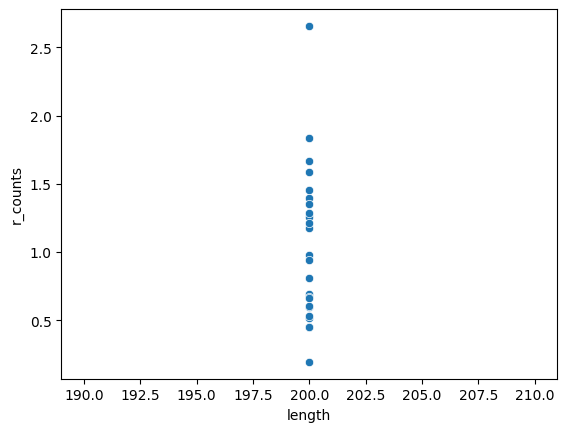

In [27]:
# link between size of amplicon and total read count
sns.scatterplot(data=sanity_amplicon,x='length',y='r_counts')

### GC bias

In [28]:
sanity_amplicon.id = sanity_amplicon.id.apply(str)
sanity_amplicon = sanity_amplicon.set_index('id')

In [29]:
sanity_amplicon = sanity_amplicon.join(normal_cell_expectation[['GC']])
sanity_amplicon

,CHROM,start_pos,end_pos,length,r_counts,GC
id,,,,,,
b'AML_v2_NRAS_115256512',chr1,1508,1708,200,1.453103,0.517413
b'AML_v2_NRAS_115258635',chr1,412,612,200,1.257997,0.467662
b'AML_v2_DNMT3A_25457166',chr2,1344,1544,200,0.974308,0.502488
b'AML_v2_DNMT3A_25458540',chr2,1430,1630,200,1.839343,0.552239
b'AML_v2_DNMT3A_25459813',chr2,1994,2194,200,0.447832,0.457711
b'AML_v2_DNMT3A_25461902',chr2,300,500,200,1.668179,0.502488
b'AML_v2_DNMT3A_25463127',chr2,272,472,200,1.288679,0.487562
b'AML_v2_DNMT3A_25463515',chr2,532,732,200,0.691341,0.487562
b'AML_v2_DNMT3A_25464443',chr2,649,849,200,0.515971,0.547264


<Axes: xlabel='length', ylabel='GC'>

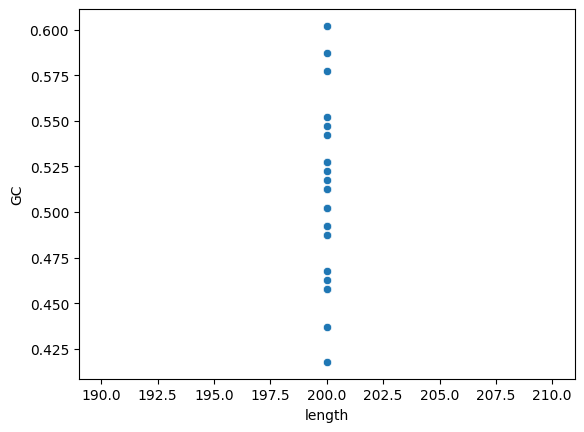

In [30]:
# link between size of amplicon and GC content
sns.scatterplot(data=sanity_amplicon,x='length',y='GC')

<Axes: xlabel='GC', ylabel='r_counts'>

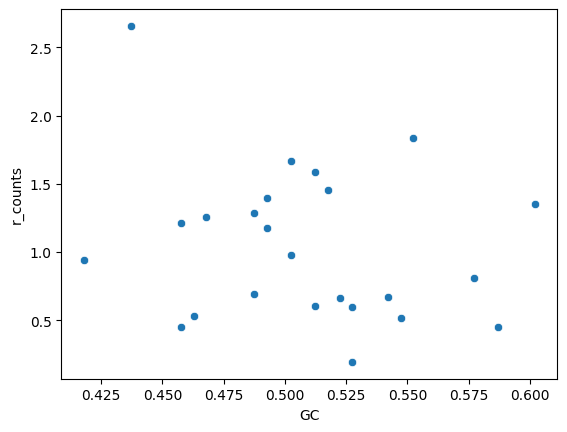

In [31]:
# link between GC content of amplicon and read count
sns.scatterplot(data=sanity_amplicon,x='GC',y='r_counts')

In [ ]:
# GC bias after normalization
#sns.scatterplot(data=sanity_amplicon,x='GC',y='r1_counts')

# Comparison

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


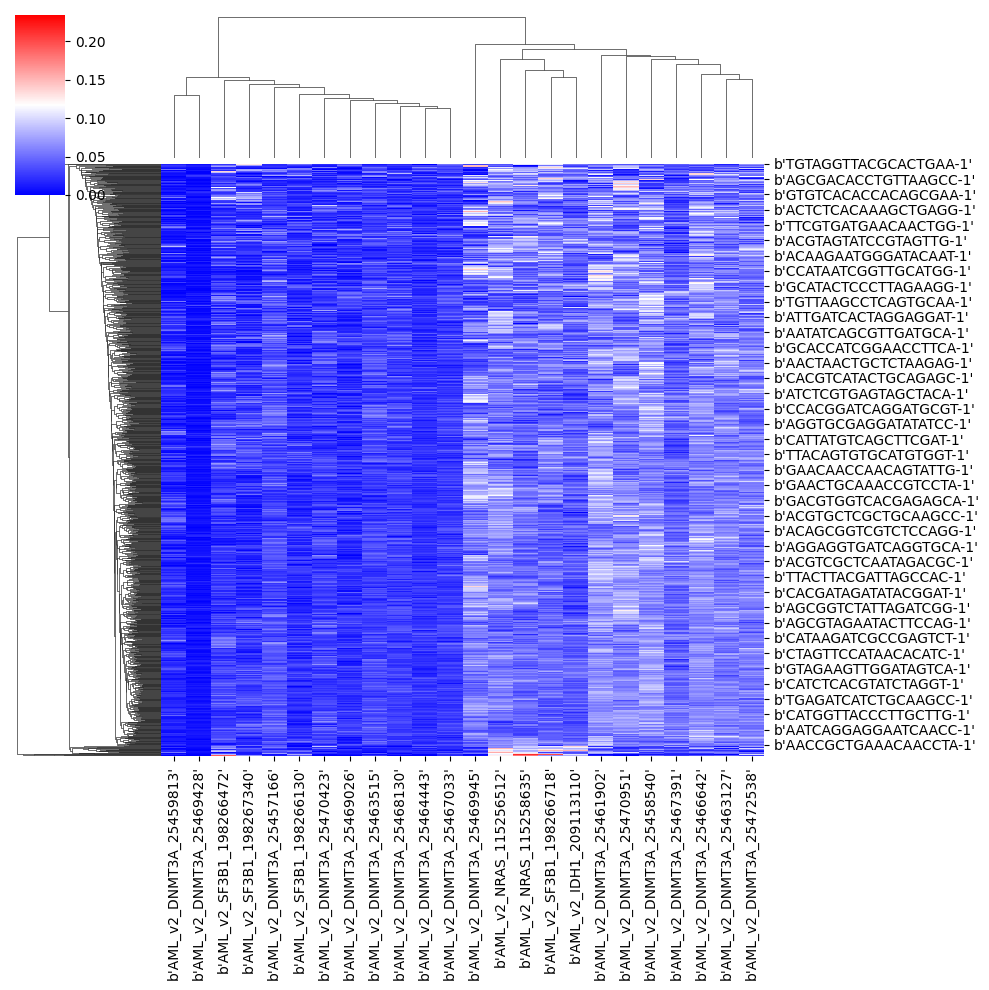

In [32]:
no_norm_cluster = sns.clustermap(small_read_counts.apply(lambda x : x/small_read_counts.sum(axis=1), axis=0),cmap="bwr")
no_norm_cluster

In [33]:
no_norm_cluster.dendrogram_row.reordered_ind
no_norm_cluster.dendrogram_col.reordered_ind

24

/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/sopchr/anaconda3/envs/seqdemo/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


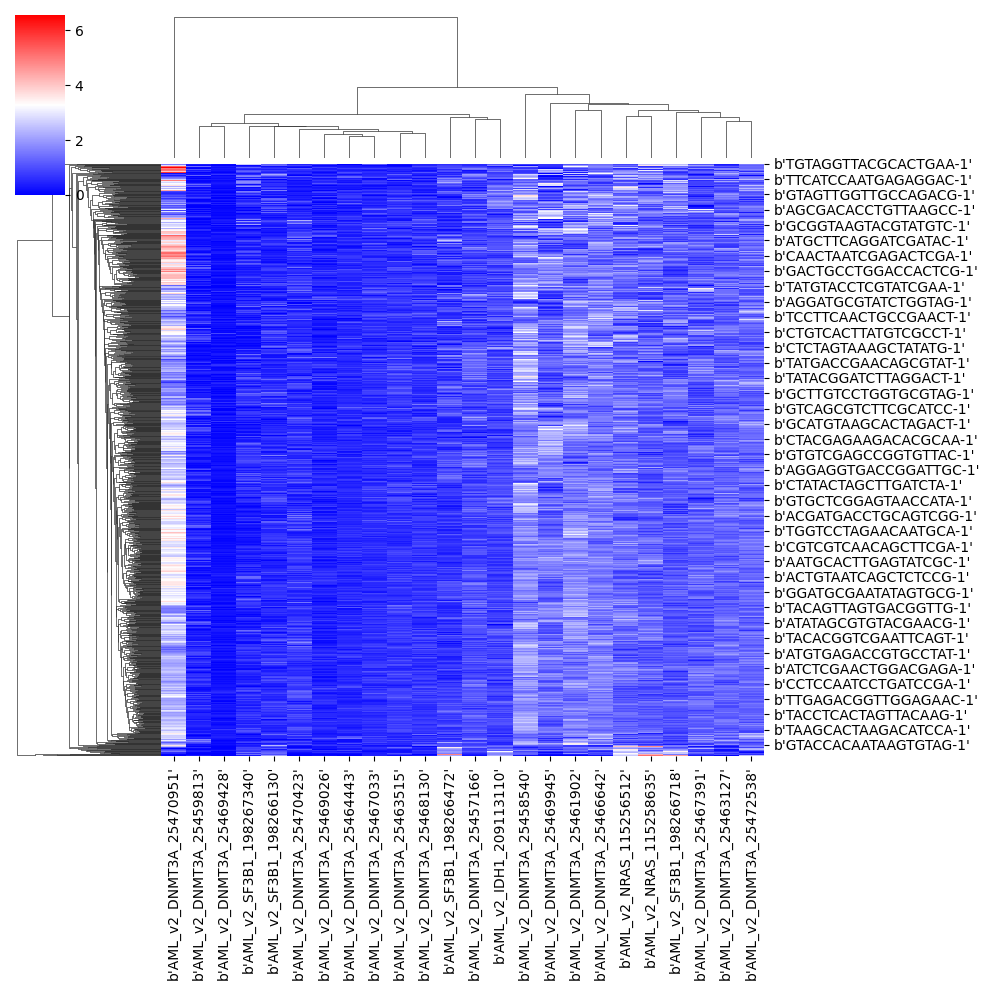

In [33]:
sns.clustermap(norm_read_count.T,cmap="bwr")

In [34]:
norm_read_count_reorder = norm_read_count.T[norm_read_count.T.columns.values[no_norm_cluster.dendrogram_col.reordered_ind]].copy()
norm_read_count_reorder = norm_read_count_reorder.reindex(norm_read_count_reorder.index.values[no_norm_cluster.dendrogram_row.reordered_ind])

<Axes: >

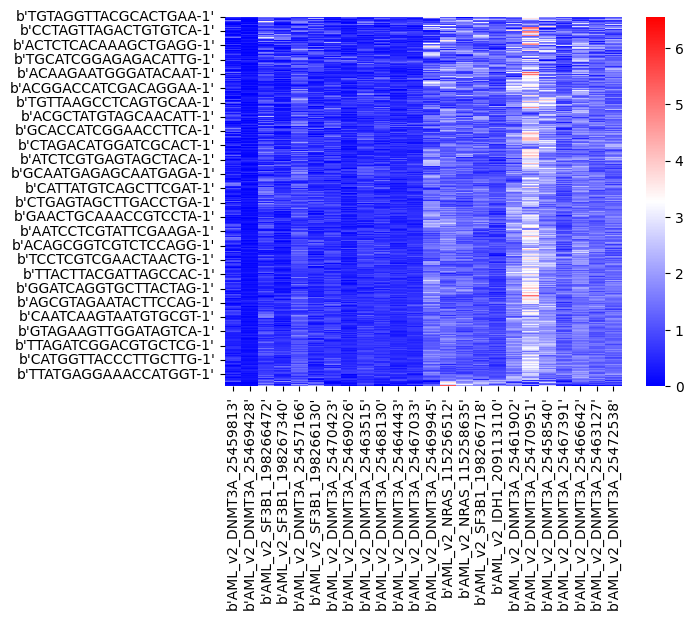

In [35]:
sns.heatmap(norm_read_count_reorder, cmap='bwr')